# 1. Feature evaluation
## Load dependencies and data

Note that tourney_level, player_1, player_2 and surface should only be used to evaluate specific situations since these are not a "difference feature". All other features for a match is the difference in performance/situation for the two players.

In [99]:
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')
sns.set(style="whitegrid")

# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

# Split data set into train and test, start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Initial model parameters
rf_max_depth = 10  # arbitrary number used only feature evaluation
rf_estimators = 100  # future default in sklearn
lr_solver = 'lbfgs'  # Only supports Ridge regularization

# Timing logger
def logger(f):
    def wrapper(df, *args, **kwargs):
        start = dt.datetime.now()
        result = f(df, *args, **kwargs)
        end = dt.datetime.now()
        
        if isinstance(result, tuple):
            shape = ''
            
            for r in result:
                shape += str(r.shape)
        else:
            shape = result.shape
        
        print(f"{f.__name__} took={end - start} shape={shape}")
        return result
    return wrapper

## Extract training and validation data

In [90]:
@logger
def start_pipe(df):
    return df.copy()

@logger
def extract_train_data(df, date_split):
    df = df.loc[data.tourney_date < date_split]
    return df.dropna()
 
@logger
def one_hot_encode(df):
    df = pd.get_dummies(df, columns=['home_advantage'])

    renames = {
        'home_advantage_-1.0': 'p2_home',
        'home_advantage_0.0': 'none_home',
        'home_advantage_1.0': 'p1_home',
    }

    return df.rename(columns=renames)

@logger
def prune_columns(df):
    # These are only interested for evaluating specific situations
    drop_cols = ['outcome', 'tourney_date', 'tourney_level', 'player_1', 'player_2', 'surface']
    df_y = df.outcome
    df_x = df.drop(drop_cols, axis=1)
    return df_x, df_y

X_train_full, y_train_full = (data
    .pipe(extract_train_data, test_date_begin)
    .pipe(one_hot_encode)
    .pipe(prune_columns))

# Split into validation and training part
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)

display(X_train)

extract_train_data took=0:00:00.036005 shape=(91435, 18)
one_hot_encode took=0:00:00.043050 shape=(91435, 20)
prune_columns took=0:00:00.003606 shape=(91435, 14)(91435,)


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,age_diff,p2_home,none_home,p1_home
13005,-0.328981,-0.372376,1.443146,1.522080,2.290345,0.138407,-0.035488,-0.092580,0.004406,0.000408,0.471819,0,1,0
38678,-0.605043,-0.652218,-0.000751,-0.000729,0.000642,0.263015,-0.138409,-0.902241,-2.890145,0.000408,-0.277343,0,1,0
62320,0.223142,-0.185814,0.265753,0.442694,2.460596,-0.070811,1.937613,-0.425970,-0.062909,-2.326092,1.973712,0,1,0
63574,-0.108132,0.280591,0.134490,0.396018,-0.235625,-0.140037,0.518388,0.097928,0.509270,0.410967,-0.926617,0,1,0
61359,0.664842,0.700355,-0.000751,-0.000729,0.000642,-1.026136,0.014618,0.574199,0.004406,0.000408,0.764350,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,0.664842,1.026839,-0.000751,-0.000729,0.000642,-1.006137,0.280045,-0.378343,-0.332169,0.274114,-0.223831,0,1,0
55010,-0.218557,-2.611118,-0.000751,-0.000729,0.000642,1.202956,-0.023300,-0.283089,-0.163882,0.000408,-1.782803,0,1,0
76963,-0.439406,-2.331275,-0.000751,-0.000729,0.000642,0.055335,-0.856147,-0.330716,1.418024,0.000408,-0.644789,0,1,0
863,-0.439406,-0.325735,-0.000751,-0.000729,0.000642,0.044567,-0.948234,-0.997495,-0.433142,0.000408,1.279845,0,1,0


## Correlation heatmap of all features

This shows a high correlation between some of the features (which is naturual). Find out which to remove by checking the feature importance in the next steps.

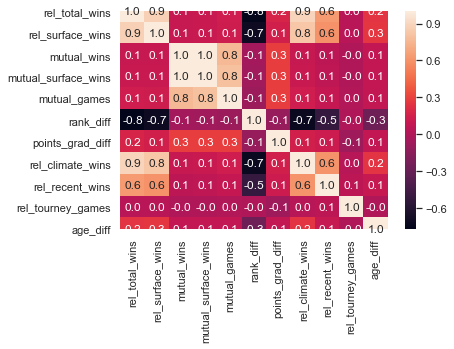

In [77]:
X_train_heat = X_train.drop(['p2_home', 'none_home', 'p1_home'], axis=1)
sns.heatmap(X_train_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance by RandomForest
Which features help split our tree in the best way possible, i.e. how does each feature affect the accuracy of our model?

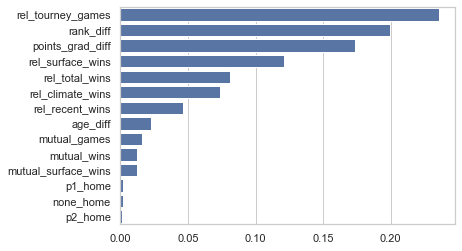

In [78]:
rf_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model.fit(X_train, y_train)

def plot_rf_feat_imp(importances, columns):
    feat_imp = pd.Series(importances, index=columns)
    feat_imp = feat_imp.sort_values(ascending=False)
    sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
    plt.show()

plot_rf_feat_imp(rf_model.feature_importances_, X_train.columns)

## Recursive feature elimination by RandomForest
Prunes the results from previous sections by selecting the 4 most important features. A ranking of 1 means the algorithm suggests the feature. Results correspond to plot above.

In [85]:
rfe_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rfe_model = RFE(rfe_model, n_features_to_select=4)  # selects 4 of the features
rfe_model.fit(X_train, y_train)

rankings = rfe_model.ranking_
idx = np.argsort(rankings)
rankings = rankings[idx]
columns = X_train.columns[idx]

rfe_results = pd.DataFrame(rankings, index=columns, columns=['Ranking'])
rfe_results.index.name = 'Feature'
display(rfe_results)

print(f"Number of features selected: {rfe_model.n_features_}")

,Ranking
Feature,
rel_surface_wins,1
rank_diff,1
points_grad_diff,1
rel_tourney_games,1
rel_total_wins,2
rel_climate_wins,3
rel_recent_wins,4
age_diff,5
mutual_games,6


Number of features selected: 4


## Feature importance by logistic regression

Below mostly confirms 7 most important features from RF model but with different significances with the exception that mutual_games is swapt for rel_recent_matches. Note that all columns are already standardized except for the p1_home, p2_home and none_home.

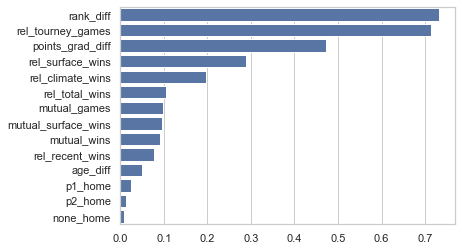

In [84]:
lr_model = LogisticRegression(solver=lr_solver)
lr_model.fit(X_train, y_train)

def plot_lr_feat_sign(X, coeffs):
    std_dev = np.std(X, 0)
    influence = std_dev*np.abs(coeffs)
    influence.sort_values(ascending=False, inplace=True)
    sns.barplot(x=influence.to_list(), y=influence.index, color='b')
    plt.show()
    
plot_lr_feat_sign(X_train, lr_model.coef_[0])

## Prune correlated and poorly significant features for both models

Keep the most significant features but remove any the highly correlated features that are less significant: rel_total_wins, rel_climate_wins. 

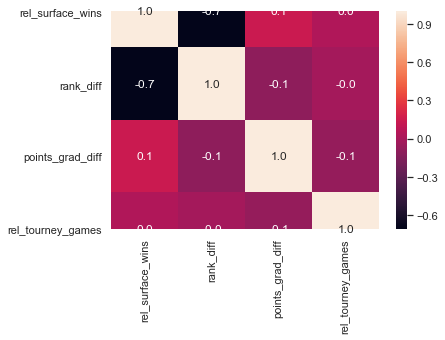

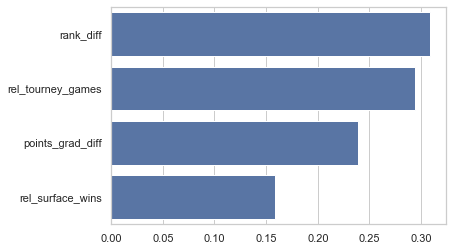

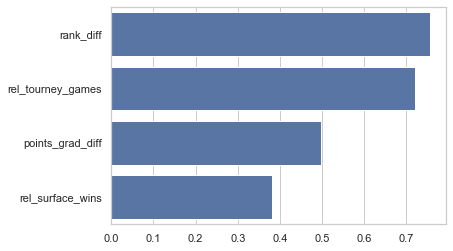

In [87]:
final_columns = ['rel_surface_wins', 'rank_diff', 'points_grad_diff', 'rel_tourney_games']
X_train_final = X_train.filter(final_columns)

# Check new correlation plot
sns.heatmap(X_train_final.corr(), annot=True, fmt='.1f')
plt.show()

rf_model_final = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model_final.fit(X_train_final, y_train)

lr_model_final = LogisticRegression(solver=lr_solver)
lr_model_final.fit(X_train_final, y_train)

# Check new feature importances and significance
print('Feature importance for Final RF Model')
plot_rf_feat_imp(rf_model_final.feature_importances_, X_train_final.columns)

print('Feature importance for Final LogReg Model')
plot_lr_feat_sign(X_train_final, lr_model_final.coef_[0])

## Check classification reports given different features

As one can see below, no performance on static validation set is lossed for any of the two algorithms. Thus since confirmed by two models, for the model selection part, even though different models may like different features, the final_column features are the ones that will be used to test different models. Also, no difference in metrics can be seen which is naturual since our data set is exactly balanced.

In [89]:
X_val_final = X_val.filter(final_columns)

print('Full RandomForest model:')
print(classification_report(y_val, rf_model.predict(X_val)))

print('Final RandomForest model:')
print(classification_report(y_val, rf_model_final.predict(X_val_final)))

print('Full LogReg model:')
print(classification_report(y_val, lr_model.predict(X_val)))

print('Final LogReg model:')
print(classification_report(y_val, lr_model_final.predict(X_val_final)))

Full RandomForest model:
              precision    recall  f1-score   support

        -1.0       0.73      0.73      0.73     15101
         1.0       0.73      0.73      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174

Final RandomForest model:
              precision    recall  f1-score   support

        -1.0       0.73      0.74      0.73     15101
         1.0       0.73      0.72      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174

Full LogReg model:
              precision    recall  f1-score   support

        -1.0       0.72      0.72      0.72     15101
         1.0       0.72      0.73      0.72     15073

    accuracy                           0.72     30174
   macro avg       0.72      0.72      0.72     30174
weig

# 2. Model Selection

This part is dedicated to model selection and hyper parameter tuning. Cross validation will be used to commpare the models.

In [102]:
no_folds = 10  # number of folds

def plot_hyperparam(accs, params):
    sns.lineplot(params, accs)
    sns.show()

## Logistic Regression

Calibration of hyperparameter C which is the inverse of regularization strength.

In [104]:
accuracies = []
hyperparams = list(np.arange(0.1, 1, 0.1))

for c in hyperparams:
    lr_model_final = LogisticRegression(solver=lr_solver, C=c)
    score = cross_val_score(rf_model, X_train_final, y_train, cv=no_folds)
    accuracies.append(score.mean())

plot_hyperparam(accuracies, hyperparams)

0.1
0.2


KeyboardInterrupt: 

## Performance on ATP main matches
Same matches as being tested, ATP 250, 500 and 1000

In [33]:
tourneys = [2,3]

drop_cols = ['outcome', 'tourney_date', 'player_1', 'player_2', 'p1_home', 'p2_home', 'none_home', 'surface', 'mutual_surface_wins', 'mutual_games', 'mutual_wins']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_val = X_val.join(y_val)
data_mask = (X_val.tourney_level.isin(tourneys))
X_val = X_val.loc[data_mask]
y_val = X_val.outcome
X_val.drop(['outcome', 'tourney_level'], inplace=True, axis=1)

X_train.drop('tourney_level', inplace=True, axis=1)

model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

print(X_train.columns)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Index(['rel_total_wins', 'rel_surface_wins', 'rank_diff', 'points_grad_diff',
       'rel_climate_wins', 'rel_recent_wins', 'rel_tourney_games', 'age_diff'],
      dtype='object')
              precision    recall  f1-score   support

        -1.0       0.66      0.66      0.66      1299
         1.0       0.67      0.67      0.67      1362

    accuracy                           0.66      2661
   macro avg       0.66      0.66      0.66      2661
weighted avg       0.66      0.66      0.66      2661



## Accuracy increase over time?
i.e. should we generate more statistics?

In [30]:
drop_cols = ['outcome', 'tourney_date', 'player_1', 'player_2', 'p1_home', 'p2_home', 'none_home', 'surface', 'mutual_surface_wins', 'mutual_games', 'tourney_level', 'mutual_wins']

# 2017-06-15
train_eval_split_low = 1497484800
train_eval_split_high = 1497484800

data_train_pre = data_train.loc[data_train.tourney_date < train_eval_split_low]
data_train_post = data_train.loc[data_train.tourney_date >= train_eval_split_high]

y_train_pre = data_train_pre.outcome
X_train_pre = data_train_pre.drop(drop_cols, axis=1)

y_train_post = data_train_post.outcome
X_train_post = data_train_post.drop(drop_cols, axis=1)

X_train_pre, X_val_pre, y_train_pre, y_val_pre = train_test_split(X_train_pre, y_train_pre, test_size=0.33, random_state=42)
X_train_post, X_val_post, y_train_post, y_val_post = train_test_split(X_train_post, y_train_post, test_size=0.33, random_state=42)

model_pre = RandomForestClassifier(max_depth=10)
model_pre.fit(X_train_pre, y_train_pre)

val_pred_pre = model_pre.predict(X_val_pre)
class_report_pre = classification_report(y_val_pre, val_pred_pre)
print(class_report_pre)

model_post = RandomForestClassifier(max_depth=10)
model_post.fit(X_train_post, y_train_post)

val_pred_post = model_post.predict(X_val_post)
class_report_post = classification_report(y_val_post, val_pred_post)
print(class_report_post)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.73      0.72      0.73      7322
         1.0       0.73      0.74      0.74      7488

    accuracy                           0.73     14810
   macro avg       0.73      0.73      0.73     14810
weighted avg       0.73      0.73      0.73     14810



/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.73      0.72      0.72      7810
         1.0       0.71      0.72      0.72      7555

    accuracy                           0.72     15365
   macro avg       0.72      0.72      0.72     15365
weighted avg       0.72      0.72      0.72     15365

